In [1]:
# first some necessary python imports
import numpy as np
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from models import WilkensLET

## SHIELD-HIT12A LET calculations

### Pencil beam simulation

 - Energy: 60 MeV
 - Energy spread: 0.5 MeV
 - Point-like source in vacuum
 - Cylindrical liquid water target (R=10cm, L=4cm)
 - DELTAE = 0.005
 - scoring dLET for protons only (the newer, better one) in cylindrical slabs 0.1mm thick (400 slabs on 4cm) of various radius
 - 10^8 particles

In [2]:
# let's load SH12A data
l1 = np.loadtxt("pencil/let_cyl1.dat")
l2 = np.loadtxt("pencil/let_cyl0p1.dat")
l3 = np.loadtxt("pencil/let_cyl0p01.dat")
l4 = np.loadtxt("pencil/let_cyl0p001.dat")

In [3]:
# let's calculate dLETp from Wilkens model
E_MeV = 60
sigma_E_MeV = 0.5
let_keV_um = WilkensLET.let_d_keV_um(E_MeV, sigma_E_MeV, l1[:,0])

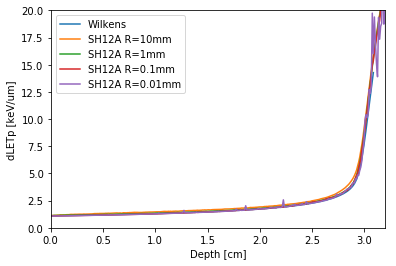

In [4]:
plt.plot(l1[:,0], let_keV_um, label="Wilkens")
plt.plot(l1[:,0],l1[:,1], label="SH12A R=10mm")
plt.plot(l2[:,0],l2[:,1], label="SH12A R=1mm")
plt.plot(l3[:,0],l3[:,1], label="SH12A R=0.1mm")
plt.plot(l4[:,0],l4[:,1], label="SH12A R=0.01mm")
plt.xlabel("Depth [cm]")
plt.ylabel("dLETp [keV/um]")
plt.ylim(0,20)
plt.xlim(0,3.2)
plt.legend(loc=0)

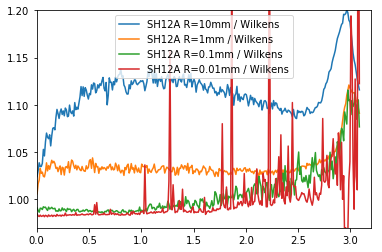

In [5]:
plt.plot(l1[:,0],l1[:,1]/let_keV_um, label="SH12A R=10mm / Wilkens")
plt.plot(l2[:,0],l2[:,1]/let_keV_um, label="SH12A R=1mm / Wilkens")
plt.plot(l3[:,0],l3[:,1]/let_keV_um, label="SH12A R=0.1mm / Wilkens")
plt.plot(l4[:,0],l4[:,1]/let_keV_um, label="SH12A R=0.01mm / Wilkens")
plt.ylim(0.97,1.2)
plt.xlim(0,3.2)
plt.legend(loc=0)

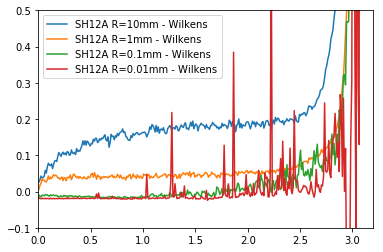

In [6]:
plt.plot(l1[:,0],l1[:,1]-let_keV_um, label="SH12A R=10mm - Wilkens")
plt.plot(l2[:,0],l2[:,1]-let_keV_um, label="SH12A R=1mm - Wilkens")
plt.plot(l3[:,0],l3[:,1]-let_keV_um, label="SH12A R=0.1mm - Wilkens")
plt.plot(l4[:,0],l4[:,1]-let_keV_um, label="SH12A R=0.01mm - Wilkens")
plt.ylim(-0.1,0.5)
plt.xlim(0,3.2)
plt.legend(loc=0)

### Broad beam simulation

 - Disc-like source in vacuum with radius 2mm
 - Rest of settings as in pencil beam

In [7]:
# let's load SH12A data
b1 = np.loadtxt("broad/let_cyl1.dat")
b2 = np.loadtxt("broad/let_cyl0p1.dat")
b3 = np.loadtxt("broad/let_cyl0p01.dat")
b4 = np.loadtxt("broad/let_cyl0p001.dat")

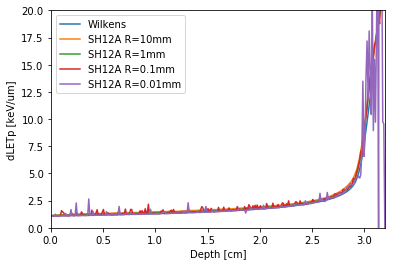

In [8]:
plt.plot(b1[:,0], let_keV_um, label="Wilkens")
plt.plot(b1[:,0],b1[:,1], label="SH12A R=10mm")
plt.plot(b2[:,0],b2[:,1], label="SH12A R=1mm")
plt.plot(b3[:,0],b3[:,1], label="SH12A R=0.1mm")
plt.plot(b4[:,0],b4[:,1], label="SH12A R=0.01mm")
plt.xlabel("Depth [cm]")
plt.ylabel("dLETp [keV/um]")
plt.ylim(0,20)
plt.xlim(0,3.2)
plt.legend(loc=0)

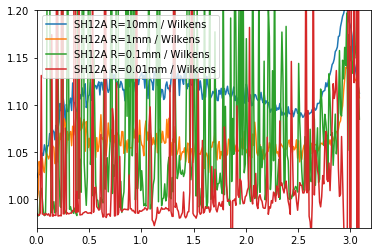

In [9]:
plt.plot(b1[:,0],b1[:,1]/let_keV_um, label="SH12A R=10mm / Wilkens")
plt.plot(b2[:,0],b2[:,1]/let_keV_um, label="SH12A R=1mm / Wilkens")
plt.plot(b3[:,0],b3[:,1]/let_keV_um, label="SH12A R=0.1mm / Wilkens")
plt.plot(b4[:,0],b4[:,1]/let_keV_um, label="SH12A R=0.01mm / Wilkens")
plt.ylim(0.97,1.2)
plt.xlim(0,3.2)
plt.legend(loc=0)

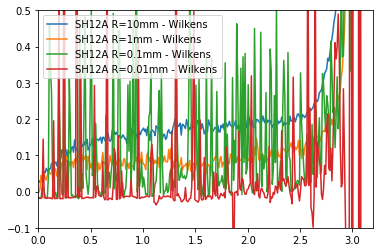

In [10]:
plt.plot(b1[:,0],b1[:,1]-let_keV_um, label="SH12A R=10mm - Wilkens")
plt.plot(b2[:,0],b2[:,1]-let_keV_um, label="SH12A R=1mm - Wilkens")
plt.plot(b3[:,0],b3[:,1]-let_keV_um, label="SH12A R=0.1mm - Wilkens")
plt.plot(b4[:,0],b4[:,1]-let_keV_um, label="SH12A R=0.01mm - Wilkens")
plt.ylim(-0.1,0.5)
plt.xlim(0,3.2)
plt.legend(loc=0)

## SHIELD-HIT12A configuration

In [11]:
!cat beam.dat

RNDSEED      	89736501     ! Random seed
JPART0       	2           ! Incident particle type
TMAX0      	60.0   0.5  ! Incident energy; (MeV/nucl)
NSTAT           10000    -1 ! NSTAT, Step of saving
! BEAMSIGMA       0.2  -0.2    ! enable to get broad beam emitted from disc with 2mm radius
STRAGG          2            ! Straggling: 0-Off 1-Gauss, 2-Vavilov
MSCAT           2            ! Mult. scatt 0-Off 1-Gauss, 2-Moliere
NUCRE           1            ! Nucl.Reac. switcher: 1-ON, 0-OFF
DELTAE          0.005



In [12]:
!cat detect.dat

*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0      10.0       7.0       4.0
                   1         1       400        -1      DOSE   d_cyl10
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0       0.1       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p1
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0      0.01       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p01
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
CYL              0.0       0.0       0.0     0.001       7.0       4.0
                   1         1       400        -1      DOSE  d_cyl0p001
*----0---><----1---><----2---><----3---><----4---><----5---><----6--->
MSH             -0.1      -0.5       0.0       0.1       0.5       4.0
   

In [13]:
!cat mat.dat

MEDIUM 1
ICRU 276
LOADDEDX
END


In [14]:
!cat geo.dat

*---><---><--------><------------------------------------------------>
    0    0           H2O 30 cm cylinder, r=10, 1 zone
*---><---><--------><--------><--------><--------><--------><-------->
  RCC    1       0.0       0.0       0.0       0.0       0.0      30.0
                10.0
  RCC    2       0.0       0.0      -5.0       0.0       0.0      35.0
                15.0
  RCC    3       0.0       0.0     -10.0       0.0       0.0      40.0
                20.0
  END
  001          +1
  002          +2     -1
  003          +3     -2      
  END
    1    2    3
    1 1000    0

